# Simple GAN Example 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
%matplotlib inline
import theano
import theano.tensor as T
from lasagne.utils import floatX
import matplotlib
import matplotlib.pyplot as plt
import lasagne
from lasagne.layers import batch_norm
import sys
import os
from PIL import Image
import scipy

In [3]:
# Define a bunch of activation functions
def leakyReLU(x):
    return T.maximum(x, 0.2*x)

In [4]:
# Define invertNL
def invertNL(x):
    return -x

In [5]:
dim = 2

def sample():
    z1 = np.random.randn()
    z2 = np.random.randn()
    z3 = np.random.randn()
    z4 = np.random.randn()
    
    return np.array([(z1 + z2)*cos(z2*(1 - z2)) + 0.05*z3, (z1 + 2)*sin((z2 - 0.5)*(z2 + 0.5)) + 0.05*z4])

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-6.50122997, -6.43795229, -6.37467461, -6.31139693, -6.24811925,
        -6.18484157, -6.12156389, -6.05828621, -5.99500853, -5.93173085,
        -5.86845317, -5.80517549, -5.74189781, -5.67862013, -5.61534245,
        -5.55206477, -5.48878709, -5.42550941, -5.36223173, -5.29895405,
        -5.23567637, -5.17239869, -5.10912101, -5.04584332, -4.98256564,
        -4.91928796, -4.85601028, -4.7927326 , -4.72945492, -4.66617724,
        -4.60289956, -4.53962188, -4.4763442 , -4.41306652, -4.34978884,
        -4.28651116, -4.22323348, -4.1599558 , -4.09667812, -4.03340044,
        -3.97012276, -3.90684508, -3.8435674 , -3.78028972, -3.71701204,
        -3.65373436, -3.59045668, -3.527179  , -3.4639013

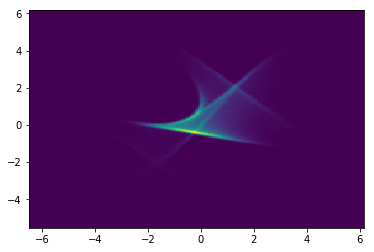

In [6]:
# Lets make a bunch of samples and visualize the distribution
dist = np.zeros((1000000, dim))
for i in range(dist.shape[0]):
    dist[i] = sample()
    
plt.hist2d(dist[:, 0], dist[:, 1], 200)

In [7]:
# Now lets define the GAN

invar1 = T.matrix()
invar2 = T.matrix()
target = T.ivector()

# Number of variables in the latent space

controldim = 8

# Generator layer sizes

N0 = 16
N1 = 16
N2 = 16
N3 = 16
N4 = 16

# discriminator layer sizes

D1 = 64
D2 = 64
D3 = 64
D4 = 64

In [11]:
# Build the model

def build_model():
    net = {}

    # Generator
    
    net["gen_input"] = lasagne.layers.InputLayer(shape=(None, controldim), input_var = invar1 )

    net["gen_layer1"] = lasagne.layers.DenseLayer(incoming = net["gen_input"], num_units = N0, nonlinearity = leakyReLU)
    net["gen_layer2"] = lasagne.layers.DenseLayer(incoming = net["gen_layer1"], num_units = N1, nonlinearity = leakyReLU)
    net["gen_layer3"] = lasagne.layers.DenseLayer(incoming = net["gen_layer2"], num_units = N2, nonlinearity = leakyReLU)
    net["gen_layer4"] = lasagne.layers.DenseLayer(incoming = net["gen_layer3"], num_units = N3, nonlinearity = leakyReLU)
    net["gen_layer5"] = lasagne.layers.DenseLayer(incoming = net["gen_layer4"], num_units = N4, nonlinearity = leakyReLU)

    net["gen_dcg_out"] = lasagne.layers.DenseLayer(incoming = net["gen_layer5"], num_units = dim, nonlinearity = None)
    
    # Discriminator 
    # This is the version that receives input from the generator
    net["inline_disc_1"] = lasagne.layers.DenseLayer(incoming = net["gen_dcg_out"], num_units = D1, nonlinearity = leakyReLU)
    net["inline_disc_2"] = lasagne.layers.DenseLayer(incoming = net["inline_disc_1"], num_units = D2, nonlinearity = leakyReLU)
    net["inline_disc_3"] = lasagne.layers.DenseLayer(incoming = net["inline_disc_2"], num_units = D3, nonlinearity = leakyReLU)
    net["inline_disc_4"] = lasagne.layers.DenseLayer(incoming = net["inline_disc_3"], num_units = D4, nonlinearity = leakyReLU)
    net["inline_disc_output"] = lasagne.layers.DenseLayer(incoming = net["inline_disc_4"], num_units = 2, nonlinearity = lasagne.nonlinearities.softmax)
    
    # We need to make a separate copy of the network template so that we can feed it an input that isn't coming from the generator.
    # All the weights are shared, so when we train one, we train the other too - its really all the same network
    net["disc_input"] = lasagne.layers.InputLayer(shape=(None, dim), input_var = invar2 )
    net["disc_1"] = lasagne.layers.DenseLayer(incoming = net["disc_input"], num_units = D1, nonlinearity = leakyReLU, W = net["inline_disc_1"].W, b = net["inline_disc_1"].b)
    net["disc_2"] = lasagne.layers.DenseLayer(incoming = net["disc_1"], num_units = D2, nonlinearity = leakyReLU, W = net["inline_disc_2"].W, b = net["inline_disc_2"].b)
    net["disc_3"] = lasagne.layers.DenseLayer(incoming = net["disc_2"], num_units = D3, nonlinearity = leakyReLU, W = net["inline_disc_3"].W, b = net["inline_disc_3"].b)
    net["disc_4"] = lasagne.layers.DenseLayer(incoming = net["disc_3"], num_units = D4, nonlinearity = leakyReLU, W = net["inline_disc_4"].W, b = net["inline_disc_4"].b)
    net["disc_output"] = lasagne.layers.DenseLayer(incoming = net["disc_4"], num_units = 2, nonlinearity = lasagne.nonlinearities.softmax, W = net["inline_disc_output"].W, b = net["inline_disc_output"].b)

    net["inl_gen"], net["inl_disc"] = lasagne.layers.get_output( (net["gen_dcg_out"], net["inline_disc_output"]) )
    net["ofl_disc"] = lasagne.layers.get_output( (net["disc_output"]) )

    net["gan_params"] = lasagne.layers.get_all_params( net["gen_dcg_out"], trainable = True)
    net["disc_params"] = lasagne.layers.get_all_params( net["disc_output"], trainable = True)

    net["gen_loss"] = T.mean(-T.log(net["inl_disc"][:,1]+1e-16))
    net["disc_loss"] = lasagne.objectives.categorical_crossentropy(net["ofl_disc"],target).mean()

    net["updates_gen"] = lasagne.updates.adam(net["gen_loss"], net["gan_params"], learning_rate = 5e-4, beta1=0.5)
    net["updates_disc"] = lasagne.updates.adam(net["disc_loss"], net["disc_params"], learning_rate = 1e-3, beta1 = 0.5)

    net["train_gen"] = theano.function([invar1], net["gen_loss"], updates=net["updates_gen"], allow_input_downcast = True)
    net["train_disc"] = theano.function([invar2,target], net["disc_loss"], updates=net["updates_disc"], allow_input_downcast = True)

    net["process"] = theano.function([invar2,target], net["disc_loss"], allow_input_downcast = True)
    net["gen_images"] = theano.function([invar1], net["inl_gen"], allow_input_downcast = True)
    
    return net

net = build_model()

In [14]:
# Do batches of NEXAMPLES real, NEXAMPLES fake. 
# The batch size determines the degree to which the discriminator will care about low-density areas of the distribution
NEXAMPLES = 1500
HALFBATCH = 1500

seeds = np.random.rand( NEXAMPLES, controldim )*2-1

def generateData(rinp):
    data = net["gen_images"](rinp)
    
    return data

def trainEpoch(eidx):
    for d_iter in range(10):
        seeds = np.random.rand( NEXAMPLES, controldim )*2-1
        samples = np.zeros( (NEXAMPLES, dim ))
        
        # Generate fresh examples
        for i in range(NEXAMPLES):
            samples[i] = sample()
                
        data = generateData(seeds)

        labels = np.zeros( 2*HALFBATCH )
        labels[0:HALFBATCH] = 1
        d_error = net["train_disc"]( samples, labels[0:HALFBATCH] )/2.0
        d_error += net["train_disc"]( data , labels[HALFBATCH:] )/2.0
    
    seeds = np.random.rand( NEXAMPLES, controldim )*2-1
    gen_error = net["train_gen"]( seeds )
    
    return gen_error, d_error

def visualize(eidx, show=False):
    seeds = np.random.rand( 100000, controldim )*2-1
    data = generateData(seeds)
    plt.hist2d(data[:,0],data[:,1],150,range=[ [-3,3], [-3,4]])
    plt.xlim(-3,3)
    plt.ylim(-3,4)
    if show:
        plt.show()
    else:
        plt.savefig("frames/%.6d.png" % eidx) # Generate animation frames

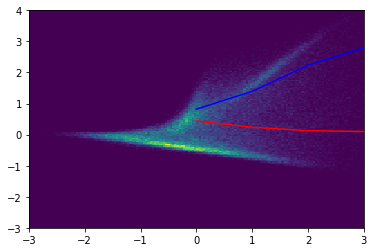

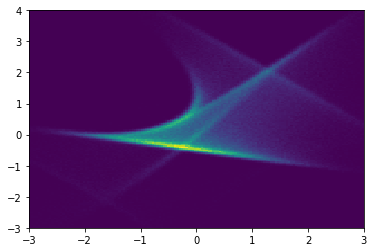

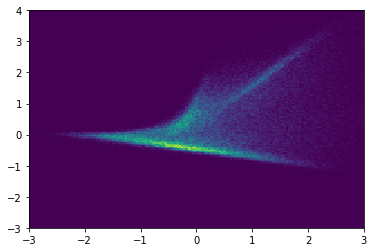

In [15]:
# Do 1000 batches

gerr = []
derr = []

for i in range(1000):
    ge,de = trainEpoch(i)
    gerr.append(ge)
    derr.append(de)
    
    if i%10 == 0:
        visualize(i)

plt.plot(gerr,"b-")
plt.plot(derr,"r-")
plt.show()
plt.clf()

plt.hist2d(dist[:,0],dist[:,1],150,range=[ [-3,3], [-3,4]])
plt.show()
plt.clf()

visualize(1000, show=True)